In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
!pip install einops

In [ ]:
import math
from einops import rearrange
import torch
from torch import nn
from torchtext.data import Field
from torchtext.data import Iterator
from torchtext.datasets import TranslationDataset

import numpy as np
import pandas as pd

# Unzipping the dadaset

### 1

In [ ]:
!unzip "/content/drive/MyDrive/deep_lab/numbers__place_value.zip" -d "/content/drive/MyDrive/deep_lab"

Archive:  /content/drive/MyDrive/deep_lab/numbers__place_value.zip
replace /content/drive/MyDrive/deep_lab/numbers__place_value/train.y? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: 
new name: o
  inflating: /content/drive/MyDrive/deep_lab/o  
replace /content/drive/MyDrive/deep_lab/numbers__place_value/train.x? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace /content/drive/MyDrive/deep_lab/numbers__place_value/train.x? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace /content/drive/MyDrive/deep_lab/numbers__place_value/train.x? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### getting familiar with the daset

In [ ]:
filename = "/content/drive/MyDrive/deep_lab/numbers__place_value/train.x"
questions = pd.read_csv(filename, header= None)

filename = "/content/drive/MyDrive/deep_lab/numbers__place_value/interpolate.x"
questions_val = pd.read_csv(filename, header= None)
questions.head()

,0
0,What is the hundreds digit of 31253?
1,What is the units digit of 8196?
2,What is the ten thousands digit of 37118?
3,What is the hundreds digit of 1229?
4,What is the units digit of 834?


In [ ]:
filename = "/content/drive/MyDrive/deep_lab/numbers__place_value/train.y"
answers = pd.read_csv(filename, header= None)

filename = "/content/drive/MyDrive/deep_lab/numbers__place_value/interpolate.y"
answers_val = pd.read_csv(filename, header= None)
answers.head()

,0
0,2
1,6
2,3
3,2
4,4


In [ ]:
questions = np.array(questions)
answers = np.array(answers)
num_chars = 0
num_sentences = questions.shape[0]
num_words = 0
for txt in questions:
  num_chars = num_chars + len(list(txt[0]))
  num_words = num_words + len(txt[0].split())
print('\n\nTrain set:')
print('number of sentences: ', num_sentences)
print('number of words: ', num_words)
print('number of charachters: ', num_chars)
print('average question length:', num_chars/num_sentences )

num_chars = 0
num_sentences = answers.shape[0]
for txt in answers:
  txt = str(txt[0])
  num_chars = num_chars + len(list(txt))
  num_words = num_words + len(txt.split())
print('average answer length:', num_chars/num_sentences )


questions_val = np.array(questions_val)
answers_val = np.array(answers_val)
num_chars = 0
num_sentences = questions_val.shape[0]
num_words = 0
for txt in questions_val:
  num_chars = num_chars + len(list(txt[0]))
  num_words = num_words + len(txt[0].split())
print('\n\nVlidation set:')
print('number of sentences: ', num_sentences)
print('number of words: ', num_words)
print('number of charachters: ', num_chars)
print('average question length:', num_chars/num_sentences )

num_chars = 0
num_sentences = answers_val.shape[0]
for txt in answers_val:
  txt = str(txt[0])
  num_chars = num_chars + len(list(txt))
  num_words = num_words + len(txt.split())
print('average answer length:', num_chars/num_sentences )



Train set:
number of sentences:  1999998
number of words:  14531838
number of charachters:  76429949
average question length: 38.21501271501271
average answer length: 1.0


Vlidation set:
number of sentences:  10000
number of words:  73641
number of charachters:  403219
average question length: 40.3219
average answer length: 1.0


### 3

In [ ]:
raw_text = ""
for txt in questions:
  raw_text = raw_text + txt[0]
chars = sorted(list(set(raw_text)))
print('number of unique charachters(vocab size): ', len(chars))

number of unique charachters(vocab size):  29


# preparing the dataset to train and test the model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
split_chars = lambda x: list(x)
folder = '/content/drive/MyDrive/deep_lab/numbers__place_value/'
TRAIN_FILE_NAME = "train"
VALID_FILE_NAME = "interpolate"

INPUTS_FILE_ENDING = ".x"
TARGETS_FILE_ENDING = ".y"

source_field = Field(tokenize=split_chars ,
                    init_token='<sos>',
                    eos_token='<eos>',
                    batch_first=True)
target_field = Field(tokenize=split_chars ,
                    init_token='<sos>',
                    eos_token='<eos>',
                    batch_first=True)


train_dataset , valid_dataset , _ = TranslationDataset.splits(
    path=folder ,
    root=folder ,
    exts=(INPUTS_FILE_ENDING , TARGETS_FILE_ENDING),
    fields=(source_field , target_field),
    train=TRAIN_FILE_NAME ,
    validation=VALID_FILE_NAME,
    test=VALID_FILE_NAME)

In [ ]:
train_bs = 64
train_iterator = Iterator(
    dataset=train_dataset ,
    batch_size=train_bs ,
    train=True,
    repeat=False,
    shuffle=True,
    device=device)

val_iterator = Iterator(
    dataset=valid_dataset ,
    batch_size=train_bs ,
    train=False,
    repeat=False,
    shuffle=False,
    device=device)

In [ ]:
train_iterator

In [ ]:
source_field.build_vocab(train_dataset)
target_field.build_vocab(valid_dataset)

In [ ]:
vocabs = source_field.vocab.stoi
int2vocab = {}
for k in vocabs.keys():
    int2vocab[vocabs[k]] = k
print(int2vocab[5])
len(vocabs)

t


33

In [ ]:
target_vocabs = target_field.vocab.stoi
int2vocab = {}
for k in target_vocabs.keys():
    int2vocab[target_vocabs[k]] = k
print(int2vocab[5])
len(target_vocabs)

2


14

In [ ]:
vocabs

defaultdict(<function torchtext.vocab._default_unk_index>,
            {' ': 4,
             '0': 28,
             '1': 18,
             '2': 20,
             '3': 21,
             '4': 22,
             '5': 23,
             '6': 24,
             '7': 25,
             '8': 26,
             '9': 27,
             '<eos>': 3,
             '<pad>': 1,
             '<sos>': 2,
             '<unk>': 0,
             '?': 14,
             'W': 15,
             'a': 12,
             'b': 32,
             'd': 9,
             'e': 10,
             'f': 16,
             'g': 17,
             'h': 7,
             'i': 6,
             'l': 30,
             'm': 31,
             'n': 13,
             'o': 11,
             'r': 29,
             's': 8,
             't': 5,
             'u': 19})

In [ ]:
target_vocabs

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'0': 13,
             '1': 4,
             '2': 5,
             '3': 7,
             '4': 9,
             '5': 11,
             '6': 12,
             '7': 10,
             '8': 8,
             '9': 6,
             '<eos>': 3,
             '<pad>': 1,
             '<sos>': 2,
             '<unk>': 0})

In [ ]:
b = next(iter(train_iterator))
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'src', 'trg'])

In [ ]:
print('source: ',b.src[0], '\n\ntarget: ', b.trg[0])

source:  tensor([ 2, 15,  7, 12,  5,  4,  6,  8,  4,  5,  7, 10,  4,  7, 19, 13,  9, 29,
        10,  9,  8,  4,  9,  6, 17,  6,  5,  4, 11, 16,  4, 18, 26, 28, 23, 24,
        22, 28, 23, 25, 14,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       device='cuda:0') 

target:  tensor([ 2, 13,  3], device='cuda:0')



# creatin gthe model

## 1

In [ ]:
class PositionalEncoder(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoder, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return x

In [ ]:
# class EncoderModel(nn.Module):
#   def __init__(self, ntoken, d_model, nlayers, nhead, nhid, dropout = 0.1, max_len = 5000):
#     super(EncoderModel, self).__init__()

#     self.ntoken = ntoken
#     self.d_model = d_model
#     self.nlayers = nlayers
#     self.nhead = nhead
#     self.nhid = nhid
#     self.dropout = dropout

#     self.embedding = nn.Embedding(self.ntoken, self.d_model)
#     self.pe = PositionalEncoder(self.d_model, dropout=self.dropout,
#                                 max_len=max_len)
#     layers = nn.TransformerEncoderLayer(d_model=self.d_model,
#                                         nhead=self.nhead,
#                                         dim_feedforward=self.nhid)#,dropout=self.dropout)
#     self.transformer_encoder = nn.TransformerEncoder(encoder_layer=layers, num_layers=self.nlayers)
#   def forward(self, src, src_pad_mask):
#     """
#     Shapes:
#         src : (source sequence length, batch size)
#         src_pad_mask : (batch size, source sequence length)
#     """
#     embeds = self.embedding(src)
#     pes = self.pe(embeds)
#     encoded = self.transformer_encoder(pes, src_key_padding_mask=src_pad_mask)
#     return encoded

In [ ]:
# class DecoderModel(nn.Module):
#   def __init__(self, ntoken, d_model, nlayers, nhead, nhid, dropout = 0.1, max_len = 5000):
#     super(DecoderModel, self).__init__()
#     self.ntoken = ntoken
#     self.d_model = d_model
#     self.nlayers = nlayers
#     self.nhead = nhead
#     self.nhid = nhid
#     self.dropout = dropout

#     self.embedding = nn.Embedding(self.ntoken, self.d_model)
#     self.pe = PositionalEncoder(d_model=self.d_model, dropout=self.dropout, max_len=max_len)
#     layer = nn.TransformerDecoderLayer(d_model=self.d_model,
#                                        nhead=self.nhead,
#                                        dim_feedforward=self.nhid)#,dropout=self.dropout)
#     self.transformer_decoder = nn.TransformerDecoder(decoder_layer=layer,
#                                             num_layers=self.nlayers)

#   def forward(self, tgt, memory, tgt_mask, tgt_pad_mask, mem_pad_mask):
#     """
#     Shapes:
#         tgt: (target sequence length, batch size)`
#         memory: (source sequece length, batch size, feature number)
#         tgt_mask: (target sequence length, target sequence length)
#         tgt_pad_mask: (batch size, target sequence length)
#         mem_pad_mask: (batch size, memory sequence length)
#     """
#     embeds = self.embedding(tgt)
#     pes = self.pe(embeds)
#     decoded = self.transformer_decoder(tgt=pes, memory=memory, tgt_mask=tgt_mask,
#                                        tgt_key_padding_mask=tgt_pad_mask,
#                                        memory_key_padding_mask=mem_pad_mask)

#     return decoded


In [ ]:
class TransformerModel(nn.Module):
  def __init__(self, ntoken_src, ntoken_trg, d_model, nlayers_enc, nlayers_dec, nhead, nfeed, dropout = 0.1, max_len = 5000):
    super(TransformerModel, self).__init__()

    self.ntoken_src = ntoken_src
    self.ntoken_trg = ntoken_trg
    self.d_model = d_model
    self.nlayers_enc = nlayers_enc
    self.nlayers_dec = nlayers_dec
    self.nhead = nhead
    self.dropout = dropout
    self.max_len = max_len
    self.nfeed = nfeed
    self.embedding_src = nn.Embedding(self.ntoken_src, self.d_model)
    self.embedding_trg = nn.Embedding(self.ntoken_trg, self.d_model)
    self.pe = PositionalEncoder(d_model=self.d_model, dropout=self.dropout, max_len=max_len)
    self.transformer = nn.Transformer(self.d_model, self.nhead, self.nlayers_enc, self.nlayers_dec, self.nfeed)
    # self.encoder = EncoderModel(self.ntoken_src, self.d_model, self.nlayers_enc,
    #                        self.nhead, nhid = self.nhid, dropout=self.dropout, max_len = self.max_len)
    # self.decoder = DecoderModel(self.ntoken_trg, self.d_model, self.nlayers_dec,
    #                        self.nhead, nhid = self.nhid, dropout=self.dropout, max_len = self.max_len)
    self.linear = nn.Linear(d_model, ntoken_trg)
  def forward(self, src, tgt, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask):
    src = self.embedding_src(src)
    src = self.pe(src)

    tgt = self.embedding_trg(tgt)
    tgt = self.pe(tgt)
    decoded = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask,
                               memory_key_padding_mask=mem_pad_mask)
    # encoded = self.encoder(src, src_pad_mask)
    # decoded = self.decoder(tgt, encoded, tgt_mask, tgt_pad_mask, mem_pad_mask)
    #print('decoded.shape ', decoded.shape)
    out = rearrange(decoded, 't n e -> n t e')
    out = self.linear(out)
    out = rearrange(out, 'n t e -> n e t')
    return out

  def generate_square_subsequent_mask(self, sz):
    """
      This is copied from nn.Transformer and it uses 0, -inf to pad
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def gen_pad_masks(self, src, target, pad_token, src_len, target_len, batch_size = 512):
    src_pad_mask = (src == pad_token).transpose(1, 0)
    tgt_pad_mask = (target == pad_token).transpose(1, 0)
    mem_pad_mask = src_pad_mask.clone()
    return src_pad_mask, tgt_pad_mask, mem_pad_mask

## simpple test of the model

In [ ]:
ntoken = len(vocabs)
ntoken_trg = len(target_vocabs)
d_model = 256
nhead = 8
nlayers = 8
nfeed= 1024
pad_token = 1
# instantiations
model = TransformerModel(ntoken,ntoken_trg, d_model, nlayers, nlayers, nhead, nfeed).to(device)
src = b.src
src = src.reshape(src.shape[1], src.shape[0])
tgt = b.trg
tgt = tgt.reshape(tgt.shape[1], tgt.shape[0])
# masks
src_pad_mask, tgt_pad_mask, mem_pad_mask = model.gen_pad_masks(src,
                                                                 tgt, pad_token,
                                                                 src.shape[0],
                                                                 tgt.shape[0], batch_size = 64)
src_pad_mask = src_pad_mask.to(device)
tgt_pad_mask = tgt_pad_mask.to(device)
mem_pad_mask = mem_pad_mask.to(device)
tgt_mask = model.generate_square_subsequent_mask(tgt.shape[0]).to(device)

output = model( src, tgt, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask)
print(output.shape)

torch.Size([64, 14, 3])


In [ ]:
output

torch.Size([62, 14, 2])

# creating a function to predict

In [ ]:
def greedy_search(model, src_val, batch_size, sos_token = 2, pad_token = 1, c1 = 3, c2 = 52):
  #softmax = nn.Softmax(-1)
  init_dec = torch.ones(1, batch_size, dtype=torch.long)*sos_token
  init_dec = init_dec.to(device)
  src_pad_mask, tgt_pad_mask, mem_pad_mask = model.gen_pad_masks(src_val,
                                                                 init_dec, pad_token,
                                                                 src_val.shape[0],
                                                                 init_dec.shape[0], batch_size = batch_size)

  src_pad_mask = src_pad_mask.to(device)
  tgt_pad_mask = tgt_pad_mask.to(device)
  mem_pad_mask = mem_pad_mask.to(device)

  src_val_embed = model.embedding_src(src_val)
  src_val_embed = model.pe(src_val_embed)

  memory = model.transformer.encoder(src_val_embed, src_key_padding_mask=src_pad_mask)
  tgt_mask = model.generate_square_subsequent_mask(init_dec.shape[0]).to(device)

  init_dec_emb = model.embedding_trg(init_dec)
  init_dec_emb = model.pe(init_dec_emb)

  dec_out = model.transformer.decoder(init_dec_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=mem_pad_mask)
  #dec_out = softmax(dec_out)
  dec_out = rearrange(dec_out, 't n e -> n t e')
  out = model.linear(dec_out)

  loss_out = out.clone()
  argmax = out.argmax(-1)
  argmax = rearrange(argmax, 'n t -> t n')

  init_dec = torch.cat([init_dec, argmax])
  dec_in = init_dec.clone()
  c2_ = 0
  c1_ = 0
  while c1_ < c1 and c2_ < c2:
    c2_ += 1
    src_pad_mask, tgt_pad_mask, mem_pad_mask = model.gen_pad_masks(src_val,
                                                                   dec_in, pad_token,
                                                                   src_val.shape[0],
                                                                   dec_in.shape[0], batch_size = batch_size)

    src_pad_mask = src_pad_mask.to(device)
    tgt_pad_mask = tgt_pad_mask.to(device)
    mem_pad_mask = mem_pad_mask.to(device)
    tgt_mask = model.generate_square_subsequent_mask(dec_in.shape[0]).to(device)

    dec_in_embed = model.embedding_src(dec_in)
    dec_in_embed = model.pe(dec_in_embed)
    dec_out = model.transformer.decoder(dec_in_embed, memory, tgt_mask, tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=mem_pad_mask)
    #dec_out = softmax(dec_out)
    dec_out = rearrange(dec_out, 't n e -> n t e')
    out = model.linear(dec_out)

    loss_out = torch.cat([loss_out, out[:, -1, :].unsqueeze(1)], dim=1)

    argmax = out.argmax(-1)
    argmax = rearrange(argmax, 'n t -> t n')
    init_dec = torch.cat([init_dec, argmax[-1:]])
    dec_in = init_dec.clone()
    c1_ = dec_in.shape[0]

  loss_out = rearrange(loss_out, 'n t e -> n e t')
  init_dec = rearrange(init_dec[1:], 't n -> n t')

  return init_dec, loss_out

In [ ]:
ntoken = len(vocabs)
ntoken_trg = len(target_vocabs)
d_model = 256
nhead = 8
nlayers = 8
nfeed = 1024
pad_token = 1
# instantiations
model = TransformerModel(ntoken,ntoken_trg, d_model, nlayers, nlayers, nhead, nfeed).to(device)

In [ ]:
src = b.src
src.shape

torch.Size([64, 52])

In [ ]:
src = b.src
src = src.reshape(src.shape[1], src.shape[0])
tgt = b.trg
tgt = tgt.reshape(tgt.shape[1], tgt.shape[0])
dec_out = greedy_search(model, src, batch_size = 64, sos_token = 2, pad_token = 1, c1 = tgt.shape[0], c2 = src.shape[0])

In [ ]:
dec_out[0].shape

torch.Size([64, 2])

In [ ]:
dec_out[0]

tensor([[ 8,  3],
        [ 7,  3],
        [13,  3],
        [ 8,  3],
        [13,  3],
        [13,  3],
        [ 7,  3],
        [ 7,  3],
        [ 7,  3],
        [ 7,  3],
        [10,  3],
        [12,  3],
        [10,  3],
        [10,  3],
        [13,  3],
        [ 9,  3],
        [10,  3],
        [10,  3],
        [ 7,  3],
        [ 9,  3],
        [ 4,  3],
        [ 4,  3],
        [ 7,  3],
        [13,  3],
        [ 9,  3],
        [13,  3],
        [13,  3],
        [ 4,  3],
        [ 5,  3],
        [10,  3],
        [10,  3],
        [ 5,  3],
        [10,  3],
        [ 7,  3],
        [ 4,  3],
        [ 5,  3],
        [ 9,  3],
        [ 5,  3],
        [12,  3],
        [ 9,  3],
        [ 5,  3],
        [ 6,  3],
        [12,  3],
        [ 4,  3],
        [11,  3],
        [ 7,  3],
        [ 4,  3],
        [ 5,  3],
        [ 9,  3],
        [ 7,  3],
        [ 5,  3],
        [ 7,  3],
        [ 8,  3],
        [13,  3],
        [ 8,  3],
        [1

# calculating accuracy

In [ ]:
def accuracy(target, predicted):
  x = torch.all(torch.eq(target, predicted), dim  = 1)
  x = x.type(torch.FloatTensor)
  return 100 * (torch.sum(x)/target.shape[0])



# train the model

In [ ]:
ntoken = len(vocabs)
ntoken_trg = len(target_vocabs)
d_model = 256
nhead = 8
nlayers_enc = 3
nlayers_dec = 2
nfeed = 1024
pad_token = 1
# instantiations
model = TransformerModel(ntoken, ntoken_trg, d_model, nlayers_enc, nlayers_dec, nhead, nfeed).to(device)

In [ ]:
from torch.optim import Adam
#criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm.notebook import tqdm

update_every = 5
batch_size = 128
num_epochs = 4
train_steps = len(train_iterator)
val_steps = len(val_iterator)
train_iter = iter(train_iterator)

best_acc = 0

train_loss = []
val_losses = []

train_acc = []
val_acc = []

total_step = 0
for epoch in range(num_epochs):
  print('\nEpoch: ', epoch)
  running_loss = []
  running_acc = []
  pbar = tqdm(range(train_steps))
  stps = 0
  acc = 0
  for step in pbar:
    model.train()
    total_step += 1
    batch = next(train_iter)
    src, tgt = batch.src, batch.trg
    src, tgt = src.to(device), tgt.to(device)

    src = src.transpose(1, 0)  # change - transpose to swap dimensions
    tgt = tgt.transpose(1, 0)
    tgt_inp, tgt_out = tgt[:-1, :], tgt[ 1:, :].transpose(1, 0)
    src_pad_mask, tgt_pad_mask, mem_pad_mask = model.gen_pad_masks(src,
                                                                    tgt_inp, pad_token,
                                                                    src.shape[0],
                                                                    tgt_inp.shape[0], batch_size = src.shape[1])

    src_pad_mask = src_pad_mask.to(device)
    tgt_pad_mask = tgt_pad_mask.to(device)
    mem_pad_mask = mem_pad_mask.to(device)
    tgt_mask = model.generate_square_subsequent_mask(tgt_inp.shape[0]).to(device)

    # Forward
    #model.reset_history()

    output = model( src, tgt_inp, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask)
    # output_ = output.view(-1, ntoken_trg)
    # tgt_ = tgt_out.view(-1)
    loss = criterion(output, tgt_out)
    loss.backward()  # calculate gradients

    acc = accuracy(tgt_out, output.argmax(1))
    running_acc.append(acc)
    running_loss.append(loss.detach().cpu().numpy())
    # Backprop and update
    if total_step%update_every == 0:
      stps = stps + 1
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()
      optimizer.zero_grad() # check - zero gradients after updating weights


    if total_step%400 == 0:  #print every 400 steps
      train_loss.append(np.mean(running_loss))
      train_acc.append(np.mean(running_acc))
      print(f'Step = {total_step}')
      s = "train_loss=%2.4f ,train_accuracy=%2.4f"%(np.mean(running_loss), np.mean(running_acc))
      running_loss = []
      running_acc = []
      pbar.set_description(s)
      print(s)


      # Validate every epoch
      val_iter = iter(val_iterator)
      stps = 0
      acc = 0
      pbar_val = range(val_steps)
      with torch.no_grad():
        running_val_loss = []
        running_val_acc = []
        for step in pbar_val:
          stps += 1
          batch = next(val_iter)
          src, tgt = batch.src, batch.trg
          src, tgt = src.to(device), tgt.to(device)

          src = src.transpose(1, 0)  # change - transpose to swap dimensions
          tgt = tgt.transpose(1, 0)
          tgt_inp, tgt_out = tgt[:-1, :], tgt[ 1:, :].transpose(1, 0)

          # Forward
          output, loss_out = greedy_search(model, src, batch_size = src.shape[1], sos_token = 2, pad_token = 1, c1 = tgt.shape[0], c2 = src.shape[0])
          loss = criterion(loss_out, tgt_out)
          running_val_loss.append(loss.cpu().numpy())
          acc = accuracy(tgt_out, output)
          running_val_acc.append(acc)

        val_acc.append(np.mean(running_val_acc))
        val_losses.append(np.mean(running_val_loss))
        s = "val_loss=%2.4f ,val_accuracy=%2.4f"%(val_losses[-1], val_acc[-1])

        print(s)
        if val_acc[-1] > best_acc:
          best_acc = val_acc[-1]
          torch.save(model, '/content/drive/MyDrive/deep_lab/models/transformer_model.pth')


Epoch:  0


Step = 400
train_loss=1.1662 ,train_accuracy=20.7148
val_loss=0.8985 ,val_accuracy=32.3248
Step = 800
train_loss=0.7677 ,train_accuracy=37.8164
val_loss=0.8209 ,val_accuracy=33.0016
Step = 1200
train_loss=0.7236 ,train_accuracy=38.6992
val_loss=0.8012 ,val_accuracy=32.0462
Step = 1600
train_loss=0.7070 ,train_accuracy=37.8555
val_loss=0.7869 ,val_accuracy=31.7576
Step = 2000
train_loss=0.6879 ,train_accuracy=39.0195
val_loss=0.7791 ,val_accuracy=32.6931
Step = 2400
train_loss=0.6717 ,train_accuracy=39.3125
val_loss=0.7520 ,val_accuracy=33.2603
Step = 2800
train_loss=0.6318 ,train_accuracy=41.8516
val_loss=0.6563 ,val_accuracy=41.1127
Step = 3200
train_loss=0.5525 ,train_accuracy=48.4883
val_loss=0.6013 ,val_accuracy=44.4765
Step = 3600
train_loss=0.4050 ,train_accuracy=62.5234
val_loss=0.4465 ,val_accuracy=59.1660
Step = 4000
train_loss=0.2673 ,train_accuracy=77.2031
val_loss=0.2454 ,val_accuracy=79.0406
Step = 4400
train_loss=0.1336 ,train_accuracy=89.7461
val_loss=0.1245 ,val_accurac

StopIteration: ignored

# 1.7

## plot the result

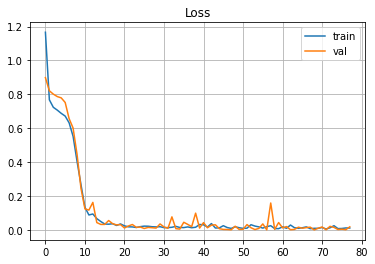

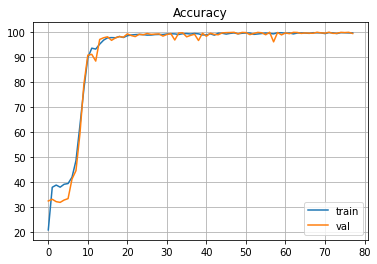

In [ ]:
# plot loss
from matplotlib import pyplot as plt
plt.plot( train_loss,'',  val_losses,'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.show()
# plot accuracy
plt.plot(train_acc,'', val_acc,'-')
plt.title('Accuracy')
plt.legend(['train','val'])
plt.grid()
plt.show()

## reducing the size of the model

In [ ]:
ntoken = len(vocabs)
ntoken_trg = len(target_vocabs)
d_model = 256
nhead = 8
nlayers_enc = 2
nlayers_dec = 2
nfeed = 512
pad_token = 1
# instantiations
model = TransformerModel(ntoken, ntoken_trg, d_model, nlayers, nlayers, nhead, nfeed).to(device)

In [ ]:
from torch.optim import Adam
#criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm.notebook import tqdm

update_every = 5
batch_size = 128
num_epochs = 1
train_steps = len(train_iterator)
val_steps = len(val_iterator)
train_iter = iter(train_iterator)

best_acc = 0

train_loss = []
val_losses = []

train_acc = []
val_acc = []

total_step = 0
for epoch in range(num_epochs):
  print('\nEpoch: ', epoch)
  running_loss = []
  running_acc = []
  pbar = tqdm(range(train_steps))
  stps = 0
  acc = 0
  for step in pbar:
    model.train()
    total_step += 1
    batch = next(train_iter)
    src, tgt = batch.src, batch.trg
    src, tgt = src.to(device), tgt.to(device)

    src = src.transpose(1, 0)  # change - transpose to swap dimensions
    tgt = tgt.transpose(1, 0)
    tgt_inp, tgt_out = tgt[:-1, :], tgt[ 1:, :].transpose(1, 0)
    src_pad_mask, tgt_pad_mask, mem_pad_mask = model.gen_pad_masks(src,
                                                                    tgt_inp, pad_token,
                                                                    src.shape[0],
                                                                    tgt_inp.shape[0], batch_size = src.shape[1])

    src_pad_mask = src_pad_mask.to(device)
    tgt_pad_mask = tgt_pad_mask.to(device)
    mem_pad_mask = mem_pad_mask.to(device)
    tgt_mask = model.generate_square_subsequent_mask(tgt_inp.shape[0]).to(device)

    # Forward
    #model.reset_history()

    output = model( src, tgt_inp, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask)
    # output_ = output.view(-1, ntoken_trg)
    # tgt_ = tgt_out.view(-1)
    loss = criterion(output, tgt_out)
    loss.backward()  # calculate gradients

    acc = accuracy(tgt_out, output.argmax(1))
    running_acc.append(acc)
    running_loss.append(loss.detach().cpu().numpy())
    # Backprop and update
    if total_step%update_every == 0:
      stps = stps + 1
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()
      optimizer.zero_grad() # check - zero gradients after updating weights


    if total_step%400 == 0:  #print every 400 steps
      train_loss.append(np.mean(running_loss))
      train_acc.append(np.mean(running_acc))
      print(f'Step = {total_step}')
      s = "train_loss=%2.4f ,train_accuracy=%2.4f"%(np.mean(running_loss), np.mean(running_acc))
      running_loss = []
      running_acc = []
      pbar.set_description(s)
      print(s)


      # Validate every epoch
      val_iter = iter(val_iterator)
      stps = 0
      acc = 0
      pbar_val = range(val_steps)
      with torch.no_grad():
        running_val_loss = []
        running_val_acc = []
        for step in pbar_val:
          stps += 1
          batch = next(val_iter)
          src, tgt = batch.src, batch.trg
          src, tgt = src.to(device), tgt.to(device)

          src = src.transpose(1, 0)  # change - transpose to swap dimensions
          tgt = tgt.transpose(1, 0)
          tgt_inp, tgt_out = tgt[:-1, :], tgt[ 1:, :].transpose(1, 0)

          # Forward
          output, loss_out = greedy_search(model, src, batch_size = src.shape[1], sos_token = 2, pad_token = 1, c1 = tgt.shape[0], c2 = src.shape[0])
          loss = criterion(loss_out, tgt_out)
          running_val_loss.append(loss.cpu().numpy())
          acc = accuracy(tgt_out, output)
          running_val_acc.append(acc)

        val_acc.append(np.mean(running_val_acc))
        val_losses.append(np.mean(running_val_loss))
        s = "val_loss=%2.4f ,val_accuracy=%2.4f"%(val_losses[-1], val_acc[-1])

        print(s)
        if val_acc[-1] > best_acc:
          best_acc = val_acc[-1]
          torch.save(model, '/content/drive/MyDrive/deep_lab/models/transformer_model_lighter.pth')


Epoch:  0


Step = 400
train_loss=0.9448 ,train_accuracy=28.8320
val_loss=0.8705 ,val_accuracy=32.0860
Step = 800
train_loss=0.7469 ,train_accuracy=38.3398
val_loss=0.8201 ,val_accuracy=33.0115
Step = 1200
train_loss=0.7150 ,train_accuracy=38.8125
val_loss=0.7986 ,val_accuracy=32.2651
Step = 1600
train_loss=0.6993 ,train_accuracy=39.3242
val_loss=0.7856 ,val_accuracy=32.9618
Step = 2000
train_loss=0.6889 ,train_accuracy=38.9336
val_loss=0.7825 ,val_accuracy=31.5784
Step = 2400
train_loss=0.6803 ,train_accuracy=38.5039
val_loss=0.7651 ,val_accuracy=32.7030
Step = 2800
train_loss=0.6711 ,train_accuracy=39.3867
val_loss=0.7627 ,val_accuracy=33.2006
Step = 3200
train_loss=0.6570 ,train_accuracy=39.4688
val_loss=0.7455 ,val_accuracy=33.4594
Step = 3600
train_loss=0.6465 ,train_accuracy=40.2422
val_loss=0.7300 ,val_accuracy=34.3850
Step = 4000
train_loss=0.6258 ,train_accuracy=41.3945
val_loss=0.7037 ,val_accuracy=36.2361
Step = 4400
train_loss=0.6015 ,train_accuracy=43.8438
val_loss=0.6737 ,val_accurac

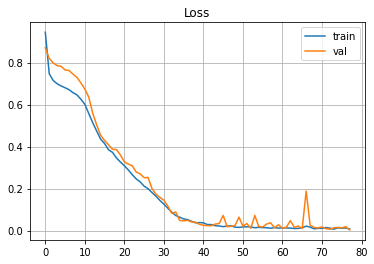

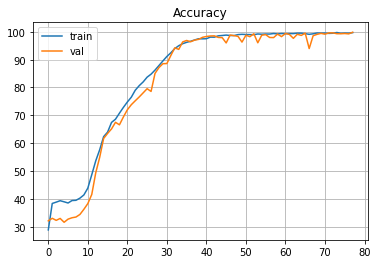

In [ ]:
# plot loss
from matplotlib import pyplot as plt
plt.plot( train_loss,'',  val_losses,'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.show()
# plot accuracy
plt.plot(train_acc,'', val_acc,'-')
plt.title('Accuracy')
plt.legend(['train','val'])
plt.grid()
plt.show()

# test another dataset

In [ ]:
!unzip "/content/drive/MyDrive/deep_lab/algebra__linear_1d.zip" -d "/content/drive/MyDrive/deep_lab"

Archive:  /content/drive/MyDrive/deep_lab/algebra__linear_1d.zip
   creating: /content/drive/MyDrive/deep_lab/algebra__linear_1d/
  inflating: /content/drive/MyDrive/deep_lab/algebra__linear_1d/train.y  
  inflating: /content/drive/MyDrive/deep_lab/algebra__linear_1d/train.x  
  inflating: /content/drive/MyDrive/deep_lab/algebra__linear_1d/interpolate.y  
  inflating: /content/drive/MyDrive/deep_lab/algebra__linear_1d/interpolate.x  


In [ ]:
split_chars = lambda x: list(x)
folder = '/content/drive/MyDrive/deep_lab/algebra__linear_1d/'
TRAIN_FILE_NAME = "train"
VALID_FILE_NAME = "interpolate"

INPUTS_FILE_ENDING = ".x"
TARGETS_FILE_ENDING = ".y"

source_field = Field(tokenize=split_chars ,
                    init_token='<sos>',
                    eos_token='<eos>',
                    batch_first=True)
target_field = Field(tokenize=split_chars ,
                    init_token='<sos>',
                    eos_token='<eos>',
                    batch_first=True)


train_dataset , valid_dataset , _ = TranslationDataset.splits(
    path=folder ,
    root=folder ,
    exts=(INPUTS_FILE_ENDING , TARGETS_FILE_ENDING),
    fields=(source_field , target_field),
    train=TRAIN_FILE_NAME ,
    validation=VALID_FILE_NAME,
    test=VALID_FILE_NAME)

In [ ]:
train_bs = 64
train_iterator = Iterator(
    dataset=train_dataset ,
    batch_size=train_bs ,
    train=True,
    repeat=False,
    shuffle=True,
    device=device)

val_iterator = Iterator(
    dataset=valid_dataset ,
    batch_size=train_bs ,
    train=False,
    repeat=False,
    shuffle=False,
    device=device)

In [ ]:
source_field.build_vocab(train_dataset)
target_field.build_vocab(valid_dataset)

In [ ]:
vocabs = source_field.vocab.stoi
int2vocab = {}
for k in vocabs.keys():
    int2vocab[vocabs[k]] = k
print(int2vocab[5])
len(vocabs)

o


47

In [ ]:
target_vocabs = target_field.vocab.stoi
int2vocab = {}
for k in target_vocabs.keys():
    int2vocab[target_vocabs[k]] = k
print(int2vocab[5])
len(target_vocabs)

2


15

In [ ]:
target_vocabs

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'-': 4,
             '0': 10,
             '1': 7,
             '2': 5,
             '3': 6,
             '4': 8,
             '5': 9,
             '6': 12,
             '7': 14,
             '8': 13,
             '9': 11,
             '<eos>': 3,
             '<pad>': 1,
             '<sos>': 2,
             '<unk>': 0})

In [ ]:
ntoken = len(vocabs)
ntoken_trg = len(target_vocabs)
d_model = 256
nhead = 8
nlayers_enc = 3
nlayers_dec = 2
nfeed = 1024
pad_token = 1
# instantiations
model = TransformerModel(ntoken, ntoken_trg, d_model, nlayers_enc, nlayers_dec, nhead, nfeed).to(device)

In [ ]:
from torch.optim import Adam
#criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm.notebook import tqdm

update_every = 5
batch_size = 64
num_epochs = 1
train_steps = len(train_iterator)
val_steps = len(val_iterator)
train_iter = iter(train_iterator)

best_acc = 0

train_loss = []
val_losses = []

train_acc = []
val_acc = []

total_step = 0
for epoch in range(num_epochs):
  print('\nEpoch: ', epoch)
  running_loss = []
  running_acc = []
  pbar = tqdm(range(train_steps))
  stps = 0
  acc = 0
  for step in pbar:
    model.train()
    total_step += 1
    batch = next(train_iter)
    src, tgt = batch.src, batch.trg
    src, tgt = src.to(device), tgt.to(device)

    src = src.transpose(1, 0)  # change - transpose to swap dimensions
    tgt = tgt.transpose(1, 0)
    tgt_inp, tgt_out = tgt[:-1, :], tgt[ 1:, :].transpose(1, 0)
    src_pad_mask, tgt_pad_mask, mem_pad_mask = model.gen_pad_masks(src,
                                                                    tgt_inp, pad_token,
                                                                    src.shape[0],
                                                                    tgt_inp.shape[0], batch_size = src.shape[1])

    src_pad_mask = src_pad_mask.to(device)
    tgt_pad_mask = tgt_pad_mask.to(device)
    mem_pad_mask = mem_pad_mask.to(device)
    tgt_mask = model.generate_square_subsequent_mask(tgt_inp.shape[0]).to(device)

    # Forward
    #model.reset_history()

    output = model( src, tgt_inp, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask)
    # output_ = output.view(-1, ntoken_trg)
    # tgt_ = tgt_out.view(-1)
    loss = criterion(output, tgt_out)
    loss.backward()  # calculate gradients

    acc = accuracy(tgt_out, output.argmax(1))
    running_acc.append(acc)
    running_loss.append(loss.detach().cpu().numpy())
    # Backprop and update
    if total_step%update_every == 0:
      stps = stps + 1
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
      optimizer.step()
      optimizer.zero_grad() # check - zero gradients after updating weights


    if total_step%400 == 0:  #print every 400 steps
      train_loss.append(np.mean(running_loss))
      train_acc.append(np.mean(running_acc))
      print(f'Step = {total_step}')
      s = "train_loss=%2.4f ,train_accuracy=%2.4f"%(np.mean(running_loss), np.mean(running_acc))
      running_loss = []
      running_acc = []
      pbar.set_description(s)
      print(s)


      # Validate every epoch
      val_iter = iter(val_iterator)
      stps = 0
      acc = 0
      pbar_val = range(val_steps)
      with torch.no_grad():
        running_val_loss = []
        running_val_acc = []
        for step in pbar_val:
          stps += 1
          batch = next(val_iter)
          src, tgt = batch.src, batch.trg
          src, tgt = src.to(device), tgt.to(device)

          src = src.transpose(1, 0)  # change - transpose to swap dimensions
          tgt = tgt.transpose(1, 0)
          tgt_inp, tgt_out = tgt[:-1, :], tgt[ 1:, :].transpose(1, 0)

          # Forward
          output, loss_out = greedy_search(model, src, batch_size = src.shape[1], sos_token = 2, pad_token = 1, c1 = tgt.shape[0], c2 = src.shape[0])
          loss = criterion(loss_out, tgt_out)
          running_val_loss.append(loss.cpu().numpy())
          acc = accuracy(tgt_out, output)
          running_val_acc.append(acc)

        val_acc.append(np.mean(running_val_acc))
        val_losses.append(np.mean(running_val_loss))
        s = "val_loss=%2.4f ,val_accuracy=%2.4f"%(val_losses[-1], val_acc[-1])

        print(s)
        if val_acc[-1] > best_acc:
          best_acc = val_acc[-1]
          torch.save(model, '/content/drive/MyDrive/deep_lab/models/transformer_model_1d_algebra.pth')


Epoch:  0


Step = 400
train_loss=0.7842 ,train_accuracy=12.6055
val_loss=4.8262 ,val_accuracy=0.3682
Step = 800
train_loss=0.7816 ,train_accuracy=13.1523
val_loss=4.8302 ,val_accuracy=0.3284
Step = 1200
train_loss=0.7866 ,train_accuracy=12.5938
val_loss=4.7991 ,val_accuracy=0.3583
Step = 1600
train_loss=0.7775 ,train_accuracy=12.4766
val_loss=4.8963 ,val_accuracy=0.3682
Step = 2000
train_loss=0.7805 ,train_accuracy=12.4453
val_loss=4.7265 ,val_accuracy=0.3583
Step = 2400
train_loss=0.7763 ,train_accuracy=12.8203
val_loss=4.8229 ,val_accuracy=0.2986
Step = 2800
train_loss=0.7731 ,train_accuracy=12.8359
val_loss=4.7861 ,val_accuracy=0.3483
Step = 3200
train_loss=0.7793 ,train_accuracy=12.9883
val_loss=4.8220 ,val_accuracy=0.2787
Step = 3600
train_loss=0.7641 ,train_accuracy=13.0820
val_loss=4.8099 ,val_accuracy=0.3284
Step = 4000
train_loss=0.7759 ,train_accuracy=13.0078
val_loss=4.8357 ,val_accuracy=0.3085
Step = 4400
train_loss=0.7691 ,train_accuracy=13.2383
val_loss=4.8631 ,val_accuracy=0.3185
S

In [ ]:
train_loss1 =  train_loss.copy()
val_losses1 = val_losses.copy()

train_acc1 = train_acc.copy()
val_acc1 = val_acc.copy()

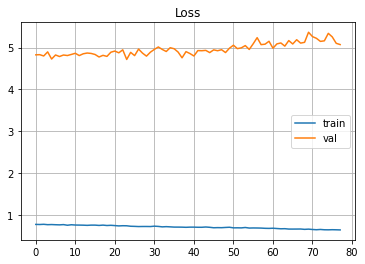

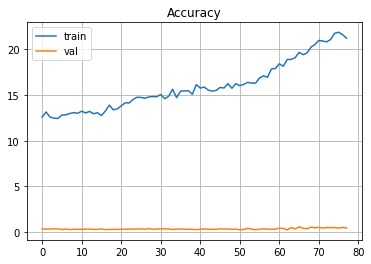

In [ ]:
# plot loss
from matplotlib import pyplot as plt
plt.plot( train_loss,'',  val_losses,'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.show()
# plot accuracy
plt.plot(train_acc,'', val_acc,'-')
plt.title('Accuracy')
plt.legend(['train','val'])
plt.grid()
plt.show()